# ToG: Satellite Image Classification with Deep

Deep Learning is a kind of model of “Machine Learning” that represents different levels of abstractions and layer layers. The last years many amazing achievements in detection and classification when using large Neural Networks CNN and GPUs.
Every year, many contest related with satellite images classification are performed. One example of this kind of contest is “ImageNet” and using CNN has dominated the contest. Many works have done on Deep Learning the progress obtained is huge, although the achievements obtained using satellite images is imitated and the reason is the difficulty to process such images efficiently with CNNs. To maintain the processing reasonable the image are imitated to 299x299. We can consider that the main reason of the scarce results is the lack of labeled datasets.

## Training data

The Database that is going to be used in this experiment is the one provided by IARPA Functional Map of the World (fMoW)1. This database has two formats. The full version that contain four or in some cases eight layers. Those images that belong to the full dataset are in TIFF format and all together are close to three and a half terabyte. There is another format compacted in RGB and that has the classical (Red, Green and Blue) layers. This second database is the one that is going to be used. This database is already separated in Training, Test, and Sequences. For this experiment, just Training and Test databases are going to be considered. As mentioned in previous experiments[2] this database will be cropped using the bounding box and all the images with cloud levels bigger than forty percent or images smaller than 5 pixels will be removed.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pandas as pd
import numpy as np
import random
import shutil
import os
#from keras.applications import xception
from keras.optimizers import adam, SGD, rmsprop
from keras.models import Model
from keras.layers import Input, merge, ZeroPadding2D
from keras.layers.core import Layer, Dense, Dropout, Activation
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2

from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, Callback, LearningRateScheduler

from keras.engine import InputSpec
from keras import initializers as initializations

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import keras.backend as K



  Using cached q-2.6-py2.py3-none-any.whl (6.8 kB)
Processing c:\users\carlos cordero\appdata\local\pip\cache\wheels\6e\9a\20\9bbadb43414356c33cef1ec1dbcc679152a2d190abb83a00eb\keras-2.0.5-py3-none-any.whl
Processing c:\users\carlos cordero\appdata\local\pip\cache\wheels\22\6b\c8\952faef457482ca081255c4a887f44f11490d1175743559aad\theano-1.0.4-py3-none-any.whl
  Attempting uninstall: keras
    Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


Using TensorFlow backend.
c:\_devtools\python\anaconda3\envs\venvcpujupyter\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\_devtools\python\anaconda3\envs\venvcpujupyter\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\_devtools\python\anaconda3\envs\venvcpujupyter\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\_d

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [3]:
###!git clone https://github.com/CARLOSALBERTOCORDERO/ToGDatabase.git


In [4]:
#img = mpimg.imread('ToGDatabase/airport/airport_0_0_msrgb.jpg')
#imgplot = plt.imshow(img)

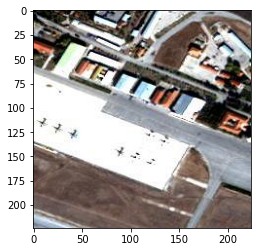

In [5]:
#CCORDERO
trainDB = "C:\\Users\\CARLOS CORDERO\\Desktop\\pretrain\\train200"
valDB = "C:\\Users\\CARLOS CORDERO\\Desktop\\pretrain\\val200"
data_set_path = "C:\\Users\\CARLOS CORDERO\\Desktop\\pretrain\\fMoW\\"
DenseNetWeights = "C:\\Users\\CARLOS CORDERO\\Desktop\\pretrain\\DenseNet-BC-161-48-no-top.h5"
#DenseNetWeights = "/content/gdrive/My Drive/Colab Notebooks/fMoW/model/DenseNet-161_acc-best.h5"
model_name = "DenseNet-161"

img = mpimg.imread(trainDB + '\\airport\\airport_0_3_msrgb.jpg')
imgplot = plt.imshow(img)

In [6]:
#lr = 2e-4  # 8e-4
#lr = 0.1
#lr = 8e-4
lr = 0.005
batch_size = 25
num_epochs = 10
pre_train_epochs = 20
# CCORDERO
num_steps_per_epoch = 30
img_rows, img_cols, img_channel = 224, 224, 3
num_categories = 62

num_snapshots = 6  # for ensemble

In [7]:
class SnapshotModelCheckpoint(Callback):
    """
    Callback that saves the snapshot weights of the model.
    Saves the model weights on certain epochs (which can be considered the
    snapshot of the model at that epoch).
    Should be used with the cosine annealing learning rate schedule to save
    the weight just before learning rate is sharply increased.
    # Arguments:
        nb_epochs: total number of epochs that the model will be trained for.
        nb_snapshots: number of times the weights of the model will be saved.
        fn_prefix: prefix for the filename of the weights.
    """

    def __init__(self, nb_epochs, nb_snapshots, fn_prefix='Model'):
        super(SnapshotModelCheckpoint, self).__init__()

        self.check = nb_epochs // nb_snapshots
        self.fn_prefix = fn_prefix

    def on_epoch_end(self, epoch, logs={}):
        if not epoch == 0 and (epoch + 1) % self.check == 0:
            file_path = data_set_path + "model\\" + self.fn_prefix + "-%d.h5" % ((epoch + 1) // self.check)
            # self.model.save_weights(file_path, overwrite=True)  # disable this code

            print("[*] Saved snapshot at model\\%s_%d.h5" % (self.fn_prefix, (epoch + 1) // self.check))


class SnapshotCallbackBuilder:
    """
    Callback builder for snapshot ensemble training of a model.
    Creates a list of callbacks, which are provided when training a model
    so as to save the model weights at certain epochs, and then sharply
    increase the learning rate.
    """

    def __init__(self, nb_epochs, nb_snapshots, init_lr=1e-3):
        """
        Initialize a snapshot callback builder.
        # Arguments:
            nb_epochs: total number of epochs that the model will be trained for.
            nb_snapshots: number of times the weights of the model will be saved.
            init_lr: initial learning rate
        """
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr

    def get_callbacks(self, model_prefix='Model'):
        """
        Creates a list of callbacks that can be used during training to create a
        snapshot ensemble of the model.
        Args:
            model_prefix: prefix for the filename of the weights.
        Returns: list of 3 callbacks [ModelCheckpoint, LearningRateScheduler,
                 SnapshotModelCheckpoint] which can be provided to the 'fit' function
        """
        # CCORDERO
        callback_list = [ModelCheckpoint(filepath=data_set_path + "model/%s_acc-best200.h5" % model_prefix,
                                         monitor="val_acc", save_best_only=True, save_weights_only=True, verbose=1),
                         LearningRateScheduler(schedule=self._cosine_anneal_schedule),
                         # LearningRateScheduler(schedule=lr_schedule),
                         # ReduceLROnPlateau(monitor='val_loss',
                         #                   patience=12, factor=0.75, cooldown=10, min_lr=1e-5, verbose=1),
                         EarlyStopping('val_loss', patience=30, verbose=1),
                         SnapshotModelCheckpoint(self.T, self.M, fn_prefix='%s' % model_prefix)]

        return callback_list

    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t % (self.T // self.M))  # t - 1 is used when t has 1-based indexing.
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1

        return float(self.alpha_zero / 2 * cos_out)


class Scale(Layer):
    """
    Learns a set of weights and biases used for scaling the input data.
    the output consists simply in an element-wise multiplication of the input
    and a sum of a set of constants:
        out = in * gamma + beta,
    where 'gamma' and 'beta' are the weights and biases larned.
    # Arguments
        axis: integer, axis along which to normalize in mode 0. For instance,
            if your input tensor has shape (samples, channels, rows, cols),
            set axis to 1 to normalize per feature map (channels axis).
        momentum: momentum in the computation of the
            exponential average of the mean and standard deviation
            of the data, for feature-wise normalization.
        weights: Initialization weights.
            List of 2 Numpy arrays, with shapes:
            `[(input_shape,), (input_shape,)]`
        beta_init: name of initialization function for shift parameter
            (see [initializations](../initializations.md)), or alternatively,
            Theano/TensorFlow function to use for weights initialization.
            This parameter is only relevant if you don't pass a `weights` argument.
        gamma_init: name of initialization function for scale parameter (see
            [initializations](../initializations.md)), or alternatively,
            Theano/TensorFlow function to use for weights initialization.
            This parameter is only relevant if you don't pass a `weights` argument.
    """

    def __init__(self, weights=None, axis=-1, momentum = 0.9, beta_init='zero', gamma_init='one', **kwargs):
        self.momentum = momentum
        self.axis = axis
        self.beta_init = initializations.get(beta_init)
        self.gamma_init = initializations.get(gamma_init)
        self.initial_weights = weights

        super(Scale, self).__init__(**kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        shape = (int(input_shape[self.axis]),)

        # Compatibility with TensorFlow >= 1.0.0
        self.gamma = K.variable(self.gamma_init(shape), name='{}_gamma'.format(self.name))
        self.beta = K.variable(self.beta_init(shape), name='{}_beta'.format(self.name))
        # self.gamma = self.gamma_init(shape, name='{}_gamma'.format(self.name))
        # self.beta = self.beta_init(shape, name='{}_beta'.format(self.name))
        self.trainable_weights = [self.gamma, self.beta]

        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights

    def call(self, x, mask=None):
        input_shape = self.input_spec[0].shape
        broadcast_shape = [1] * len(input_shape)
        broadcast_shape[self.axis] = input_shape[self.axis]

        out = K.reshape(self.gamma, broadcast_shape) * x + K.reshape(self.beta, broadcast_shape)
        return out

    def get_config(self):
        config = {"momentum": self.momentum, "axis": self.axis}
        base_config = super(Scale, self).get_config()

        return dict(list(base_config.items()) + list(config.items()))



In [8]:
def densenet161_model(img_rows, img_cols, color_type=1, nb_dense_block=4, growth_rate=48, nb_filter=96, reduction=0.5,dropout_rate=0.0, weight_decay=1e-4, num_classes=None, lr=8e-4):
    """
    DenseNet 161 Model for Keras
    Model Schema is based on
    ImageNet Pretrained Weights
    # Arguments
        nb_dense_block: number of dense blocks to add to end
        growth_rate: number of filters to add per dense block
        nb_filter: initial number of filters
        reduction: reduction factor of transition blocks.
        dropout_rate: dropout rate
        weight_decay: weight decay factor
        classes: optional number of classes to classify images
        weights_path: path to pre-trained weights
    # Returns
        A Keras model instance.
    """

    eps = 1.1e-5

    # compute compression factor
    compression = 1.0 - reduction

    # Handle Dimension Ordering for different backends
    global concat_axis

    concat_axis = 3
    img_input = Input(shape=(img_rows, img_cols, 3), name='data')

    # From architecture for ImageNet (Table 1 in the paper)
    nb_filter = 96
    nb_layers = [6, 12, 36, 24]  # For DenseNet-161

    # Initial convolution
    x = ZeroPadding2D((3, 3), name='conv1_zeropadding')(img_input)
    x = Conv2D(nb_filter, (7, 7), strides=(2, 2), name='conv1', use_bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=concat_axis, name='conv1_bn')(x)
    x = Scale(axis=concat_axis, name='conv1_scale')(x)
    x = Activation('relu', name='relu1')(x)
    x = ZeroPadding2D((1, 1), name='pool1_zeropadding')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), name='pool1')(x)

    # Add dense blocks
    for block_idx in range(nb_dense_block - 1):
        stage = block_idx+2
        x, nb_filter = dense_block(x, stage, nb_layers[block_idx], nb_filter, growth_rate, dropout_rate=dropout_rate,
                                   weight_decay=weight_decay)

        # Add transition_block
        x = transition_block(x, stage, nb_filter, compression=compression, dropout_rate=dropout_rate,
                             weight_decay=weight_decay)
        nb_filter = int(nb_filter * compression)

    final_stage = stage + 1
    x, nb_filter = dense_block(x, final_stage, nb_layers[-1], nb_filter, growth_rate, dropout_rate=dropout_rate,
                               weight_decay=weight_decay)

    x = BatchNormalization(epsilon=eps, axis=concat_axis, name='conv'+str(final_stage)+'_blk_bn')(x)
    x = Scale(axis=concat_axis, name='conv'+str(final_stage)+'_blk_scale')(x)
    x = Activation('relu', name='relu'+str(final_stage)+'_blk')(x)

    # x_fc = GlobalAveragePooling2D(name='pool'+str(final_stage))(x)
    # x_fc = Dense(1000, name='fc6')(x_fc)
    # x_fc = Activation('softmax', name='prob')(x_fc)

    model = Model(img_input, x, name='densenet')

    # weight path
    weights_path = DenseNetWeights

    model.load_weights(weights_path, by_name=True)

    # Truncate and replace softmax layer for transfer learning
    # Cannot use model.layers.pop() since model is not of Sequential() type
    # The method below works since pre-trained weights are stored in layers but not in the model
    x_newfc = GlobalAveragePooling2D(name='pool'+str(final_stage))(x)
    x_newfc = Dense(num_classes, name='fc6')(x_newfc)
    x_newfc = Activation('softmax', name='prob')(x_newfc)

    model = Model(img_input, x_newfc)

    # Learning rate is changed to 0.001
    sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [9]:
def conv_block(x, stage, branch, nb_filter, dropout_rate=None, weight_decay=1e-4):
    """
    Apply BatchNorm, Relu, bottleneck 1x1 Conv2D, 3x3 Conv2D, and option dropout
        # Arguments
            x: input tensor
            stage: index for dense block
            branch: layer index within each dense block
            nb_filter: number of filters
            dropout_rate: dropout rate
            weight_decay: weight decay factor
    """

    eps = 1.1e-5
    conv_name_base = 'conv' + str(stage) + '_' + str(branch)
    relu_name_base = 'relu' + str(stage) + '_' + str(branch)

    # 1x1 Convolution (Bottleneck layer)
    inter_channel = nb_filter * 4
    x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_x1_bn')(x)
    x = Scale(axis=concat_axis, name=conv_name_base+'_x1_scale')(x)
    x = Activation('relu', name=relu_name_base+'_x1')(x)
    x = Conv2D(inter_channel, (1, 1), name=conv_name_base+'_x1', use_bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    # 3x3 Convolution
    x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_x2_bn')(x)
    x = Scale(axis=concat_axis, name=conv_name_base+'_x2_scale')(x)
    x = Activation('relu', name=relu_name_base+'_x2')(x)
    x = ZeroPadding2D((1, 1), name=conv_name_base+'_x2_zeropadding')(x)
    x = Conv2D(nb_filter, (3, 3), name=conv_name_base+'_x2', use_bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    return x

In [10]:
def transition_block(x, stage, nb_filter, compression=1.0, dropout_rate=None, weight_decay=1e-4):
    """
    Apply BatchNorm, 1x1 Convolution, averagePooling, optional compression, dropout
        # Arguments
            x: input tensor
            stage: index for dense block
            nb_filter: number of filters
            compression: calculated as 1 - reduction. Reduces the number of feature maps in the transition block.
            dropout_rate: dropout rate
            weight_decay: weight decay factor
    """

    eps = 1.1e-5
    conv_name_base = 'conv' + str(stage) + '_blk'
    relu_name_base = 'relu' + str(stage) + '_blk'
    pool_name_base = 'pool' + str(stage)

    x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_bn')(x)
    x = Scale(axis=concat_axis, name=conv_name_base+'_scale')(x)
    x = Activation('relu', name=relu_name_base)(x)
    x = Conv2D(int(nb_filter * compression), (1, 1), name=conv_name_base, use_bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    x = AveragePooling2D((2, 2), strides=(2, 2), name=pool_name_base)(x)

    return x

In [11]:
def dense_block(x, stage, nb_layers, nb_filter, growth_rate, dropout_rate=None, weight_decay=1e-4,grow_nb_filters=True):
    """
    Build a dense_block where the output of each conv_block is fed to subsequent ones
        # Arguments
            x: input tensor
            stage: index for dense block
            nb_layers: the number of layers of conv_block to append to the model.
            nb_filter: number of filters
            growth_rate: growth rate
            dropout_rate: dropout rate
            weight_decay: weight decay factor
            grow_nb_filters: flag to decide to allow number of filters to grow
    """

    eps = 1.1e-5
    concat_feat = x

    for i in range(nb_layers):
        branch = i + 1
        x = conv_block(concat_feat, stage, branch, growth_rate, dropout_rate, weight_decay)
        concat_feat = merge([concat_feat, x], mode='concat', concat_axis=concat_axis,name='concat_' + str(stage) + '_' + str(branch))

        if grow_nb_filters:
            nb_filter += growth_rate

    return concat_feat, nb_filter

In [12]:
# Callbacks
snapshot = SnapshotCallbackBuilder(num_epochs, num_snapshots, lr)

In [13]:
train_data_gen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=270,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')
    
train_generator = train_data_gen.flow_from_directory(
    directory=trainDB,
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    class_mode='categorical'
)

val_data_gen = ImageDataGenerator(
    rescale=1. / 225,
)
val_generator = val_data_gen.flow_from_directory(
    directory=valDB,
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 11815 images belonging to 62 classes.
Found 2337 images belonging to 62 classes.


In [14]:
model = densenet161_model(img_rows=img_rows, img_cols=img_cols, color_type=img_channel, num_classes=num_categories,lr=lr)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


c:\_devtools\python\anaconda3\envs\venvcpujupyter\lib\site-packages\ipykernel_launcher.py:21: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
c:\_devtools\python\anaconda3\envs\venvcpujupyter\lib\site-packages\keras\legacy\layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


Instructions for updating:
keep_dims is deprecated, use keepdims instead
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
data (InputLayer)                (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv1_zeropadding (ZeroPadding2D (None, 230, 230, 3)   0           data[0][0]                       
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 96)  14112       conv1_zeropadding[0][0]          
____________________________________________________________________________________________________
conv1_bn (BatchNormalization)    (None, 112, 112, 96)  384         conv1[0][0]                      
__________________

relu5_19_x1 (Activation)         (None, 7, 7, 1920)    0           conv5_19_x1_scale[0][0]          
____________________________________________________________________________________________________
conv5_19_x1 (Conv2D)             (None, 7, 7, 192)     368640      relu5_19_x1[0][0]                
____________________________________________________________________________________________________
conv5_19_x2_bn (BatchNormalizati (None, 7, 7, 192)     768         conv5_19_x1[0][0]                
____________________________________________________________________________________________________
conv5_19_x2_scale (Scale)        (None, 7, 7, 192)     384         conv5_19_x2_bn[0][0]             
____________________________________________________________________________________________________
relu5_19_x2 (Activation)         (None, 7, 7, 192)     0           conv5_19_x2_scale[0][0]          
___________________________________________________________________________________________

In [15]:
model.fit_generator(
    generator=train_generator,
    validation_data=val_generator,
    steps_per_epoch=num_steps_per_epoch,
    callbacks=snapshot.get_callbacks(model_prefix=model_name),
    # initial_epoch=pre_train_epochs,
    epochs=num_epochs,
    validation_steps=num_steps_per_epoch,
    verbose=1)

# save trained weights
train_end_weights = data_set_path + 'model\\%s_train-end.h5' % model_name

model.save_weights(train_end_weights, overwrite=True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
 4/30 [===>..........................] - ETA: 1629s - loss: 4.1933 - acc: 0.0300

KeyboardInterrupt: 